<p><img alt="udeA logo" height="150px" src="https://github.com/freddyduitama/images/blob/master/logo.png?raw=true" align="left" hspace="50px" vspace="0px" style="width:107px;height:152px;"></p>
<h1><font color='0B5345'> <center>
Proyecto 2: Análisis estadístico de señales ECG</center></font></h1>
<font  face="Times New Roman" size="3">
<p1><center> Angie Triana - Erika Gómez - Ana Carolina Mejía</center></p1>

# 1. Revisión bibliográfica

Se realizó la revisión de 3 artículos. 

##### [1] *Prediction of atrial fibrillation from at-home single-lead ECG signals without arrhythmias*
##### [2] *Optimal Multi-Stage Arrhythmia Classification Approachs*
##### [3] *Prediction of atrial fibrillation from at-home single-lead ECG signals without arrhythmias*

Link de acceso al documento con la descripción y diagramas de flujo metodológicos de cada artículo: [Revisión bibliográfica](https://docs.google.com/document/d/1VY0PSuFvuRrQnc7JRg_Bi7LEMet8-5_ChNKO-_oa3M4/edit?tab=t.0)

# Importación de funciones

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import fft
import matplotlib.pyplot as plt;
import scipy.io as sio;
import seaborn as sns
from scipy.signal import detrend
from scipy.stats import ttest_ind, shapiro, levene, mannwhitneyu
from scipy import stats
import os
import zipfile
from scipy.signal import welch

# 2. Carga de datos 

De la base de datos, nuestros archivos de interés corresponden a los registros pertenecientes a los pacientes con bradicardia sinusal (SB Sinus Bradycardia) y fibrilación auricular (AFIB Atrial Fibrillation). Por lo tanto, lo primero que haremos será identificar dichos archivos, partiendo de la lectura del archivo "Diagnostics.xlsx", donde se encuentra contenida la información. Una vez identificados, se obtendrá una lista con los nombres de cada archivo para cada una de las arritmias (SB y AFIB).

## a) *Lectura del archivo "Diagnostics.xlsx"*

In [9]:
data = pd.read_excel('Diagnostics.xlsx')
data

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10641,MUSE_20181222_204306_99000,SVT,NONE,80,FEMALE,196,73,168,284,513,258,244,32,177,261,319
10642,MUSE_20181222_204309_22000,SVT,NONE,81,FEMALE,162,81,162,294,482,110,-75,27,173,254,320
10643,MUSE_20181222_204310_31000,SVT,NONE,39,MALE,152,92,152,340,540,250,38,25,208,284,378
10644,MUSE_20181222_204312_58000,SVT,NONE,76,MALE,175,178,128,310,529,98,-83,29,205,269,360


## b) *Identificación de los registros con diagnóstico SB y AFIB*

Se recorre el dataset identificando cuáles de los registros tienen "SB" o "AFIB" en la columa "Rhythm". Y se guardarán estos registros en una lista.

In [11]:
dataSB_FileName = data.loc[lambda x: x["Rhythm"] == "SB", "FileName"].tolist()
dataAFIB_FileName = data.loc[lambda x: x["Rhythm"] == "AFIB", "FileName"].tolist()

print(f"Cantidad de archivos para SB (bradicardia sinusal): {len(dataSB_FileName)}")
print(f"Cantidad de archivos para AFIB (fibrilación auricular): {len(dataAFIB_FileName)}")


Cantidad de archivos para SB (bradicardia sinusal): 3889
Cantidad de archivos para AFIB (fibrilación auricular): 1780


In [12]:
dataAFIB_FileName_csv = [f"{archivo}.csv" for archivo in dataAFIB_FileName]

In [13]:
dataSB_FileName_csv = [f"{archivo}.csv" for archivo in dataSB_FileName]

Ahora se descomprime el archivo "ECGDataDenoised.zip" para recorrer los archivos de la carpeta e identificar aquellos registros que se encuentran en las listas extraídas.

In [15]:
directorio_actual = os.getcwd()

In [16]:
folder_data = os.listdir(directorio_actual+"/ECGDataDenoised")

In [17]:
SB_registers = []
AFIB_registers = []

for archivo in folder_data:
    if archivo in dataSB_FileName_csv:
        SB_registers.append(archivo)
    elif archivo in dataAFIB_FileName_csv:
        AFIB_registers.append(archivo)

In [18]:
len(SB_registers)

3889

In [19]:
len(AFIB_registers)

1780

In [20]:
datos = []
for registro in SB_registers:
    datos.append({'Registro': registro, 'Estado': 'SB'})

for registro in AFIB_registers:
    datos.append({'Registro': registro, 'Estado': 'AFIB'})

df_rs = pd.DataFrame(datos)

print(df_rs)

                            Registro Estado
0     MUSE_20180111_155758_17000.csv     SB
1     MUSE_20180111_155839_67000.csv     SB
2     MUSE_20180111_155859_36000.csv     SB
3     MUSE_20180111_155907_78000.csv     SB
4     MUSE_20180111_160033_11000.csv     SB
...                              ...    ...
5664  MUSE_20180712_161449_58000.csv   AFIB
5665  MUSE_20180712_161451_72000.csv   AFIB
5666  MUSE_20180712_161452_78000.csv   AFIB
5667  MUSE_20180712_161503_00000.csv   AFIB
5668  MUSE_20180712_161505_16000.csv   AFIB

[5669 rows x 2 columns]


## c) *Extracción de las señales ECG de la derivación II*

Se recorre el dataset identificando cuáles de los registros tienen "SB" o "AFIB" en la columa "Rhythm". Y se guardarán estos registros en una lista.

De estos registros los análisis para el presente proyecto se harán en la derivación II, por lo que extraemos las señales ECG correspondientes a esta derivación para todos (tanto SB como AFIB).

In [22]:
def II_derivacion(carpeta, archivo, columnas):
    ruta = os.path.join(carpeta, archivo) 
    try:
        df = pd.read_csv(ruta, delimiter=',', names=columnas)
        signal = df["II"]
    except FileNotFoundError:
        print(f'El archivo {archivo} no se encontró en {carpeta}.')
    return signal

In [23]:
df_SB_files = df_rs[df_rs['Estado'] == 'SB']
df_AFIB_files = df_rs[df_rs['Estado'] == 'AFIB']


columnas = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ruta = directorio_actual + "/ECGDataDenoised"


list_SB_II = []
list_AFIB_II = []

for archivo in df_SB_files['Registro']:
    signal = II_derivacion(ruta, archivo, columnas)
    data = {"Registros": archivo, "II": signal, "Estado": "SB"}
    list_SB_II.append(data)

for archivo in df_AFIB_files['Registro']:
    signal = II_derivacion(ruta, archivo, columnas)
    data = {"Registros": archivo, "II": signal, "Estado": "AFIB"}
    list_AFIB_II.append(data)


df_f = pd.DataFrame(list_SB_II + list_AFIB_II)

In [24]:
df_f.index+=1

In [25]:
df_f

,Registros,II,Estado
1,MUSE_20180111_155758_17000.csv,0 362.880 1 310.670 2 263.87...,SB
2,MUSE_20180111_155839_67000.csv,0 20.0040 1 22.1440 2 22.996...,SB
3,MUSE_20180111_155859_36000.csv,0 -3.03400 1 -2.30080 2 -1.0...,SB
4,MUSE_20180111_155907_78000.csv,0 -26.45100 1 -8.01570 2 ...,SB
5,MUSE_20180111_160033_11000.csv,0 11.3730 1 4.3521 2 -1.206...,SB
...,...,...,...
5665,MUSE_20180712_161449_58000.csv,0 -12.0430 1 -10.8170 2 -8.734...,AFIB
5666,MUSE_20180712_161451_72000.csv,0 29.812 1 28.744 2 27.714 3...,AFIB
5667,MUSE_20180712_161452_78000.csv,0 -106.870 1 -105.040 2 -100.86...,AFIB
5668,MUSE_20180712_161503_00000.csv,0 -45.844 1 -46.678 2 -47.010 3...,AFIB


Para facilidad de manejo de los datos, se guardaran las señales de la II derivación de cada registro en carpetas "SB" ó "AFIB" según la clasificación de la arritmia.

In [27]:
def guardar_archivos(df, carpeta): #Función para guardar los registros de la II derivación
    for _, row in df.iterrows():
        nombre_archivo = row['Registros'] 
        señal = row['II']  
        ruta_guardar = os.path.join(carpeta, nombre_archivo)
        
        # Guardar la señal en un archivo .txt
        with open(ruta_guardar, 'w') as f:
            for dato in señal:
                f.write(f"{dato}\n")

In [43]:
sb_folder = "SB" 
afib_folder = "AFIB"

df_SB = df_f[df_f['Estado'] == 'SB'] 
df_AFIB = df_f[df_f['Estado'] == 'AFIB']

if not os.path.exists(sb_folder):
    os.makedirs(sb_folder)
    print(f"Carpeta '{sb_folder}' creada.")
    guardar_archivos(df_SB, sb_folder)
    print('Archivos de SB guardados correctamente')
else:
    print(f"Carpeta '{sb_folder}' ya existe.")

if not os.path.exists(afib_folder):
    os.makedirs(afib_folder)
    print(f"Carpeta '{afib_folder}' creada.")
    guardar_archivos(df_AFIB, afib_folder)
    print('Archivos de AFIB guardados correctamente')
else:
    print(f"Carpeta '{afib_folder}' ya existe.")


Carpeta 'SB' ya existe.
Carpeta 'AFIB' ya existe.


Se verifica que se hayan almacenado en las carpetas la totalidad de los archivos.

In [46]:
len(os.listdir('SB'))

3889

In [48]:
len(os.listdir('AFIB'))

1780

# 3. Programación de las fórmulas del 1 al 4 del artículo: ["Higher order spectral analysis of ECG signals"](https://arxiv.org/pdf/1809.08451)

Por propósitos de visualización del comportamiento de las señales al aplicar estas funciones sobre ellas, se realizará para dos sujetos seleccionados de manera aleatoria, uno para cada arritmia.

### 3.3 *Detrend*

Se empleará la librería de Python Scipy para eliminar las tendencias lineales de las señales.

### 3.1 *Compression*

In [54]:
def compress(signal):
    x_min = signal.min()
    x_max = signal.max()
    num = (signal) - (x_min)
    den = x_max - x_min
    compression = num/den
    return compression

### *Preprocesamiento de las señales*

Al hacer pruebas de preprocesamiento aplicándoles detrend y compresión a señales de manera aleatoria para observar su comportamiento, se identificó que al hacer la compresión se agregaba a la señal un nivel de offset. Debido a lo anterior, lo adecuado era aplicar nuevamente la función detrend una vez comprimida la señal (doble detrend).

#### *Preprocesamiento de de la señal del sujeto MUSE_20180114_121533_70000.csv - AFIB*

In [58]:
ruta_carpeta = directorio_actual + '/AFIB'
archivo = "MUSE_20180114_121533_70000.csv" 
ruta1 = ruta_carpeta + "/" + archivo

columnas=['II']
data_AFIB = pd.read_csv(ruta1, delimiter=',', names=columnas)
signal_AFIB = data_AFIB["II"].values
try:
    detrend_AFIB = detrend(signal_AFIB)
    compression_AFIB = compress(detrend_AFIB)
    detrend2_AFIB = detrend(compression_AFIB)
except FileNotFoundError:
    print(f'El archivo {archivo} no se encontró en {ruta_carpeta}.')

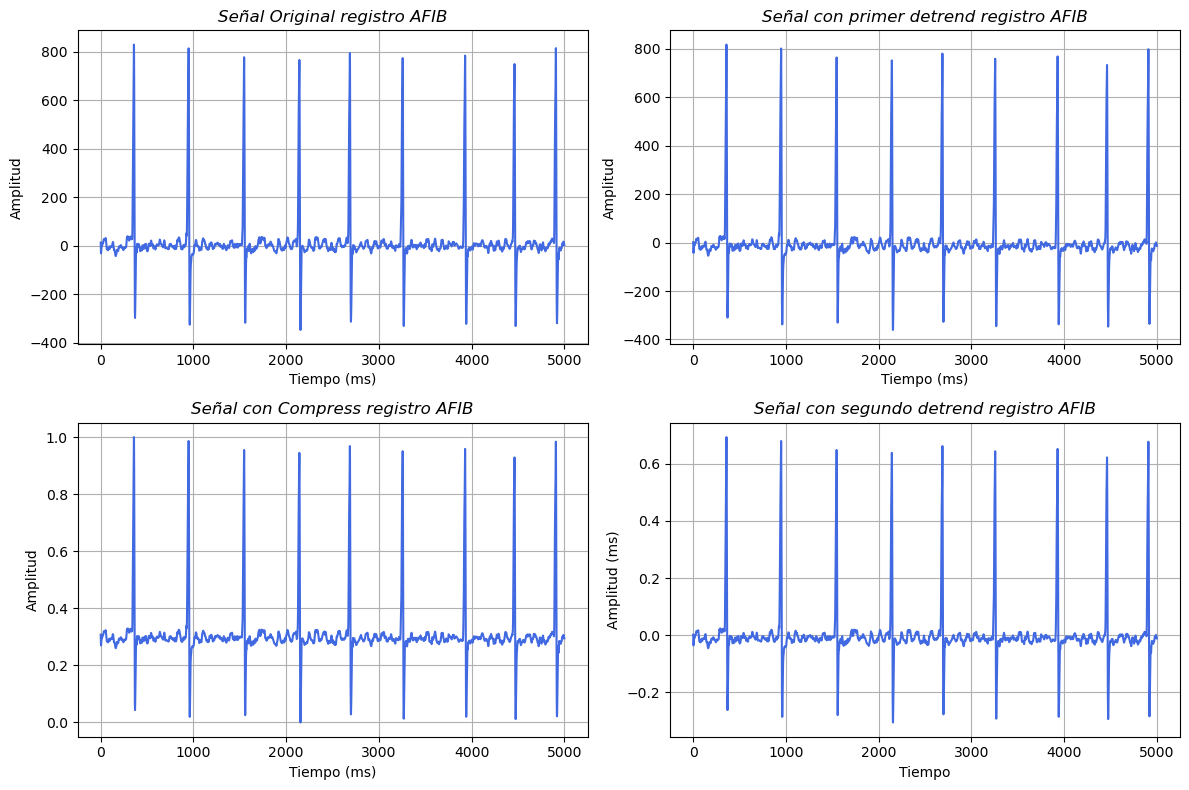

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(signal_AFIB, 'royalblue')
axs[0, 0].set_title('Señal Original registro AFIB', fontstyle = 'italic')
axs[0, 0].set_xlabel('Tiempo (ms)')
axs[0, 0].set_ylabel('Amplitud')
axs[0, 0].grid(True)

axs[0, 1].plot(detrend_AFIB, 'royalblue')
axs[0, 1].set_title('Señal con primer detrend registro AFIB', fontstyle = 'italic')
axs[0, 1].set_xlabel('Tiempo (ms)')
axs[0, 1].set_ylabel('Amplitud')
axs[0, 1].grid(True)


axs[1, 0].plot(compression_AFIB, 'royalblue')
axs[1, 0].set_title('Señal con Compress registro AFIB', fontstyle = 'italic')
axs[1, 0].set_xlabel('Tiempo (ms)')
axs[1, 0].set_ylabel('Amplitud')
axs[1, 0].grid(True)


axs[1, 1].plot(detrend2_AFIB, 'royalblue')
axs[1, 1].set_title('Señal con segundo detrend registro AFIB', fontstyle = 'italic')
axs[1, 1].set_xlabel('Tiempo')
axs[1, 1].set_ylabel('Amplitud (ms)')
axs[1, 1].grid(True)

plt.tight_layout()


plt.show()

#### *Preprocesamiento de de la señal del sujeto MUSE_20180118_124944_51000.csv - SB*

In [63]:
ruta_carpeta = directorio_actual + '/SB'
archivo = "MUSE_20180118_124944_51000.csv" 
ruta1 = ruta_carpeta + "/" + archivo

columnas=['II']
data_SB = pd.read_csv(ruta1, delimiter=',', names=columnas)
signal_SB = data_SB["II"].values

try:
    detrend_SB = detrend(signal_SB)
    compression_SB = compress(detrend_SB)
    detrend2_SB = detrend(compression_SB)
except FileNotFoundError:
    print(f'El archivo {archivo} no se encontró en {ruta_carpeta}.')

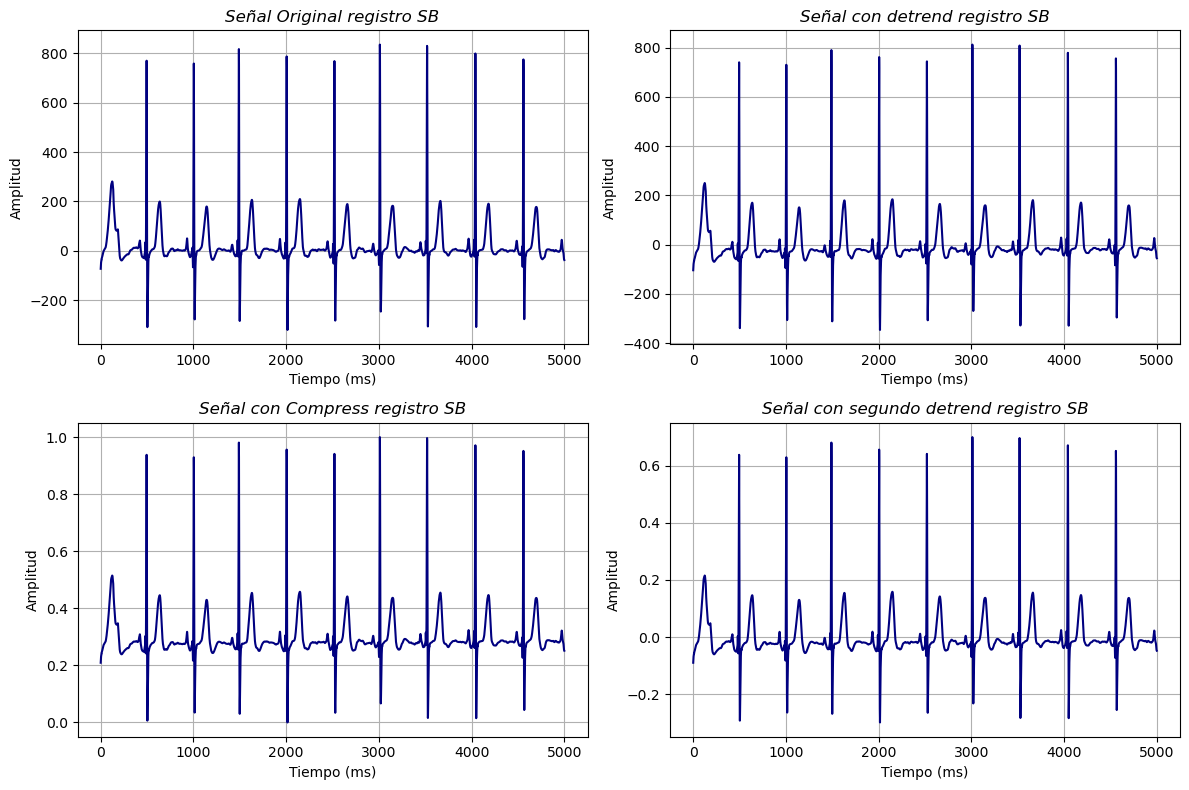

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(signal_SB, 'navy')
axs[0, 0].set_title('Señal Original registro SB', fontstyle = 'italic')
axs[0, 0].set_xlabel('Tiempo (ms)')
axs[0, 0].set_ylabel('Amplitud')
axs[0, 0].grid(True)

axs[0, 1].plot(detrend_SB, 'navy')
axs[0, 1].set_title('Señal con detrend registro SB', fontstyle = 'italic')
axs[0, 1].set_xlabel('Tiempo (ms)')
axs[0, 1].set_ylabel('Amplitud')
axs[0, 1].grid(True)

axs[1, 0].plot(compression_SB, 'navy')
axs[1, 0].set_title('Señal con Compress registro SB', fontstyle = 'italic')
axs[1, 0].set_xlabel('Tiempo (ms)')
axs[1, 0].set_ylabel('Amplitud')
axs[1, 0].grid(True)

axs[1, 1].plot(detrend2_SB, 'navy')
axs[1, 1].set_title('Señal con segundo detrend registro SB', fontstyle = 'italic')
axs[1, 1].set_xlabel('Tiempo (ms)')
axs[1, 1].set_ylabel('Amplitud')
axs[1, 1].grid(True)

plt.tight_layout()

plt.show()

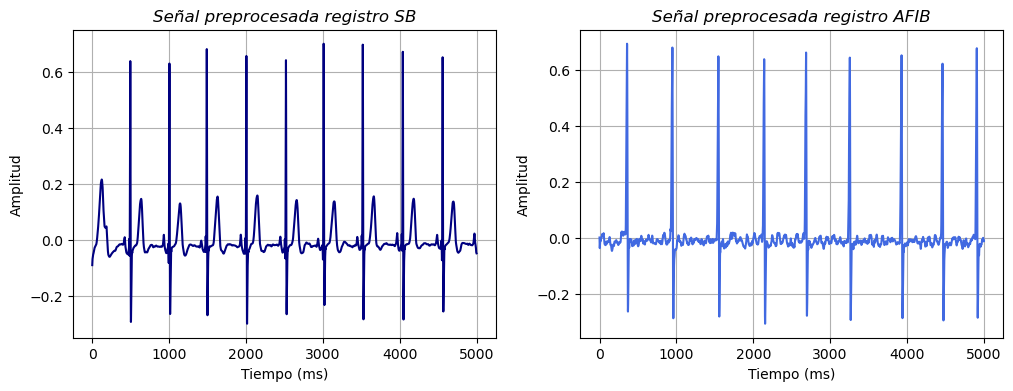

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(detrend2_SB, 'navy')
axs[0].set_title('Señal preprocesada registro SB', fontstyle = 'italic')
axs[0].set_xlabel('Tiempo (ms)')
axs[0].set_ylabel('Amplitud')
axs[0].grid(True)

axs[1].plot(detrend2_AFIB, 'royalblue')
axs[1].set_title('Señal preprocesada registro AFIB', fontstyle = 'italic')
axs[1].set_xlabel('Tiempo (ms)')
axs[1].set_ylabel('Amplitud')
axs[1].grid(True)

In [69]:
from PIL import Image 

In [71]:
img_ECG_normal = Image.open('senalECGnormal.png')

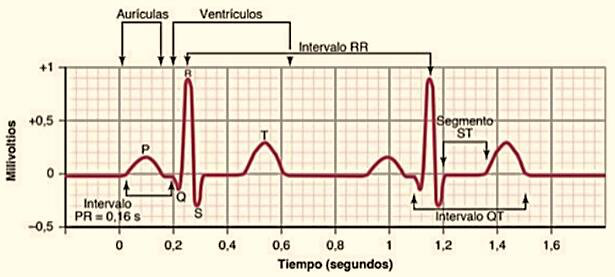

In [73]:
img_ECG_normal

Una señal ECG de un sujeto en condiciones normales tiene una frecuencia entre 60-100 LPM, lo que implica que la frecuencia de pulso se encuentra dentro del rango de 1 - 1.7 Hz. Se tiene además un intervalo R-R regular, y una diferenciación clara de la onda P (correspondiente a la despolarización de las aurículas) y el complejo QRS (asociado a la despolarización ventricular) y la onda T (correspondiente a la repolarización ventricular). La Bradicardia Sinusal es una arritmia dada por una disminución significativa en la frecuencia con la que es generado el impulso eléctrico que estimula la contracción del corazón por el nodo sinoauricular, debido a esto, está caracterizada por frecuencias bajas menores a 60 LPM, es decir, frecuencias de pulso menores a 1 Hz [1]. Por otro lado, la Fibrilación Auricular es un ritmo rápido e irregular debido a movimientos convulsivos de fibras musculares individuales del corazón. A causa de una actividad eléctrica anormal dentro de las aurículas, se produce la fibrilación de las mismas. Al latir las aurículas de forma rápida y desordenada, se tiene como resultado una contracción auricular es descoordinada. A su vez, el disparo de múltiples impulsos eléctricos de manera simultánea sobrecarga el nodo auriculoventricular (AV), provocando también un contracción ventricular irregular. Esta señal se caracteriza por tener presente en ellas frecuencias mayores a 60 LPM [2]. Al observar las señales preprocesadas de estos dos sujetos con distintas arritmias es posible identificar diferencias en las mismas. En el registro para el sujeto diagnosticado con AFIB se visualizan ritmos irregulares de alta frecuencia, donde se dificulta distinguir las ondas P precedentes al complejo QRS, que son las que indican una contracción auricular regular y del complejo QRS sólo logra identificar con claridad el pico R. Adicionalmente, se tienen intervalos R-R irregulares debido a la transmisión caótica de impulsos del nodo AV y se puede observar la presencia de frecuencias extremadamente altas. La señal ECG del sujeto con SB guarda una mayor similaridad con señales ECG de sujetos sanos, se tienen intervalos RR regulares y prolongados, las ondas P están presentes y preceden el complejo QRS. 

### 3.2 *Biespectro y Bicoherencia*

In [77]:
segmentos = 1000
fs = 500 #La frecuencia de muestreo para la adquisición de ECG especificada en los datos del dataset fue de 500 Hz.

Para este caso particular de comparación entre dos sujetos se establecerá una cantidad de segmentos igual a 1000, con la cual se obtiene una resolución de espectro de 0.5 Hz. Sin embargo, en general emplearemos una cantidad de segmentos igual a 500, en función de reducir el gasto computacional, por lo que la resolución disminuye a la mitad. Esta aclaración es importante dado que al disminuir la resolución es probable que los resultados obtenidos posteriormente podrían ser menos significativos. 

In [80]:
def bicoherencia_biespectro(signal, fs, nsegmentos):
    # Dividir la señal en segmentos
    n_segmentos = []
    indices = range(0, len(signal) - nsegmentos + 1, nsegmentos)
    for i in indices:
        segment = signal[i:i + nsegmentos]
        n_segmentos.append(segment)
    
    array_segmentos = np.array(n_segmentos)
    num_segments = array_segmentos.shape[0]
    
    # FFT de los segmentos
    fft_segments = np.fft.fft(array_segmentos, n=nsegmentos, axis=1)
    fft_segments = fft_segments[:, :nsegmentos // 2]  # Solo frecuencias positivas
    
    # Inicializar biespectro y denominador
    biespectro = np.zeros((nsegmentos // 2, nsegmentos // 2), dtype=complex)
    denominador_bicoherencia = np.zeros((nsegmentos // 2, nsegmentos // 2), dtype=float)
    
    # Loop sobre los segmentos
    for j in range(num_segments):
        S = fft_segments[j, :]
        
        # Aseguramos que f3 esté dentro de los límites
        for f1 in range(nsegmentos // 2):
            for f2 in range(nsegmentos // 2):
                f3 = f1 + f2
                if f3 < nsegmentos // 2:
                    # Forzar los valores de S[f1], S[f2], S[f3] a escalares con np.squeeze()
                    S_f1 = np.squeeze(S[f1])
                    S_f2 = np.squeeze(S[f2])
                    S_f3 = np.squeeze(S[f3])
                    
                    # Calcular el biespectro
                    biespectro[f1, f2] += S_f1 * S_f2 * np.conj(S_f3)
                    
                    # Calcular el denominador de la bicoherencia
                    denominador_bicoherencia[f1, f2] += np.abs(S_f1) * np.abs(S_f2) * np.abs(S_f3)

    # Calcular la bicoherencia
    bicoherencia = np.abs(biespectro) / (denominador_bicoherencia + np.finfo(float).eps)  # Prevenir división por 0
    
    return biespectro, bicoherencia

In [82]:
def simetria(bicoherencia):
    simetria_bicoherencia = np.zeros((10, 20))
    for f1 in range(20):
        for f2 in range(f1, 20 - f1):
            simetria_bicoherencia[f1, f2] = bicoherencia[f1, f2]
    return simetria_bicoherencia

Con propósitos de visualizar el comportamiento de las señales al aplicar estas funciones sobre ellas, se realizará para los dos sujetos seleccionados anteriormente.

In [85]:
biesespectro_AFIB, bicoherencia_AFIB= bicoherencia_biespectro(detrend2_AFIB, fs, segmentos)
sim_AFIB = simetria(bicoherencia_AFIB)

In [86]:
biesespectro_SB, bicoherencia_SB= bicoherencia_biespectro(detrend2_SB, fs, segmentos)
sim_SB = simetria(bicoherencia_SB)

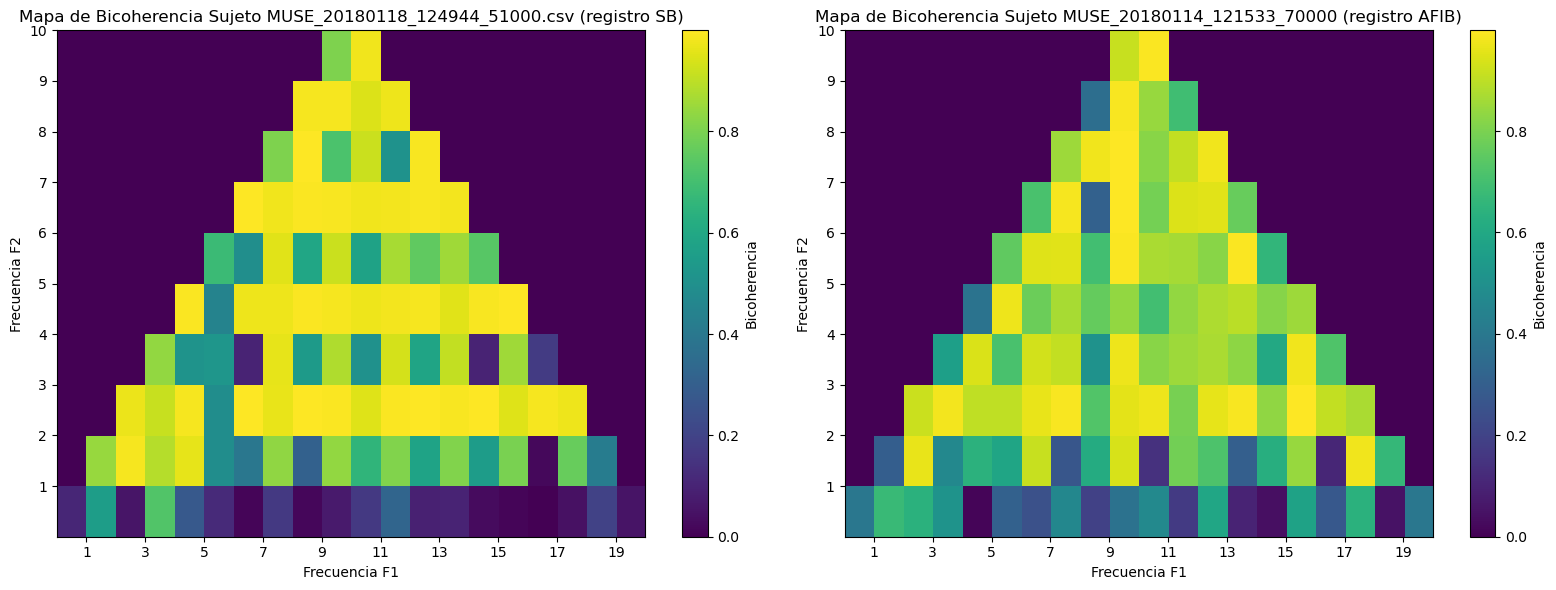

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 fila, 2 columnas

im1 = axs[0].imshow(sim_SB, extent=(0, 20, 0, 10), origin='lower', cmap='viridis', aspect='auto')
axs[0].set_title('Mapa de Bicoherencia Sujeto MUSE_20180118_124944_51000.csv (registro SB)')
axs[0].set_xlabel('Frecuencia F1')
axs[0].set_ylabel('Frecuencia F2')
axs[0].set_xticks(np.arange(1, 21, 2))  # Ajuste de ticks en el eje x
axs[0].set_yticks(np.arange(1, 11, 1))  # Ajuste de ticks en el eje y
axs[0].grid(False)


cbar1 = fig.colorbar(im1, ax=axs[0], label='Bicoherencia')

im2 = axs[1].imshow(sim_AFIB, extent=(0, 20, 0, 10), origin='lower', cmap='viridis', aspect='auto')
axs[1].set_title('Mapa de Bicoherencia Sujeto MUSE_20180114_121533_70000 (registro AFIB)')
axs[1].set_xlabel('Frecuencia F1')
axs[1].set_ylabel('Frecuencia F2')
axs[1].set_xticks(np.arange(1, 21, 2))
axs[1].set_yticks(np.arange(1, 11, 1))
axs[1].grid(False)

cbar2 = fig.colorbar(im2, ax=axs[1], label='Bicoherencia')
plt.tight_layout()

plt.show()

La bicoherencia mide la proporción de energía de la señal en cualquier par de frecuencias que esté acoplada cuadráticamente en fase. Para este caso se estableció un rango de frecuencias: para la frecuencia 1 (F1) de 0 a 20 Hz, para la frecuencia 2 (F2) de 0 a 10 Hz.A simple vista, se evidencia que el sujeto con Bradicardia Sinusal (SB, por sus siglas en inglés) presenta un mayor número de frecuencias que se encuentran acopladas cuadráticamente en fase en comparación con el sujeto diagnosticado con AFIB, dando cuenta de las diferencias estructurales entre las señales ECG de ambas arritmias.

# 4. Extracción de la frecuencia de máxima potencia (fMP) para cada señal

In [92]:
def potenciaMax(señal, fs):
    fft_values = np.fft.fft(señal)
    power_spectrum = np.abs(fft_values) ** 2
    power_spectrum = power_spectrum [:len(power_spectrum)//2]
    frequencies = np.fft.fftfreq(len(señal), 1/fs)
    frequencies=frequencies[:len(frequencies)//2]
    max_power_index = np.argmax(power_spectrum)
    max_freq = frequencies[max_power_index]
    potenciaMax=power_spectrum[max_power_index]
    return frequencies,power_spectrum,max_freq

In [94]:
frequencies_AFIB,power_spectru_AFIB,frec_max_AFIB=potenciaMax(detrend2_AFIB, fs)
frequencies_SB,power_spectru_SB,frec_max_SB=potenciaMax(detrend2_SB, fs)

In [96]:
frec_max_SB

1.0

In [98]:
frec_max_AFIB

6.7

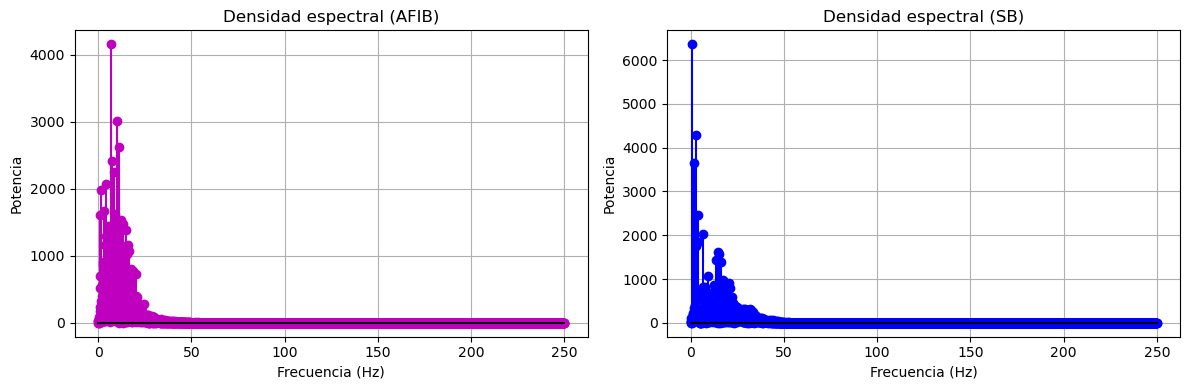

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 fila, 2 columnas

axs[0].stem(frequencies_AFIB, power_spectru_AFIB, linefmt='m-', markerfmt='mo', basefmt='k-')
axs[0].set_ylabel("Potencia")
axs[0].set_xlabel("Frecuencia (Hz)")
axs[0].set_title("Densidad espectral (AFIB)")
axs[0].set_xlim
axs[0].grid(True)

axs[1].stem(frequencies_SB, power_spectru_SB, linefmt='b-', markerfmt='bo', basefmt='k-')
axs[1].set_ylabel("Potencia")
axs[1].set_xlabel("Frecuencia (Hz)")
axs[1].set_title("Densidad espectral (SB)")
axs[1].set_xlim
axs[1].grid(True)

plt.tight_layout()

plt.show()

Hacemos zoom para visualizar mejor el espectro

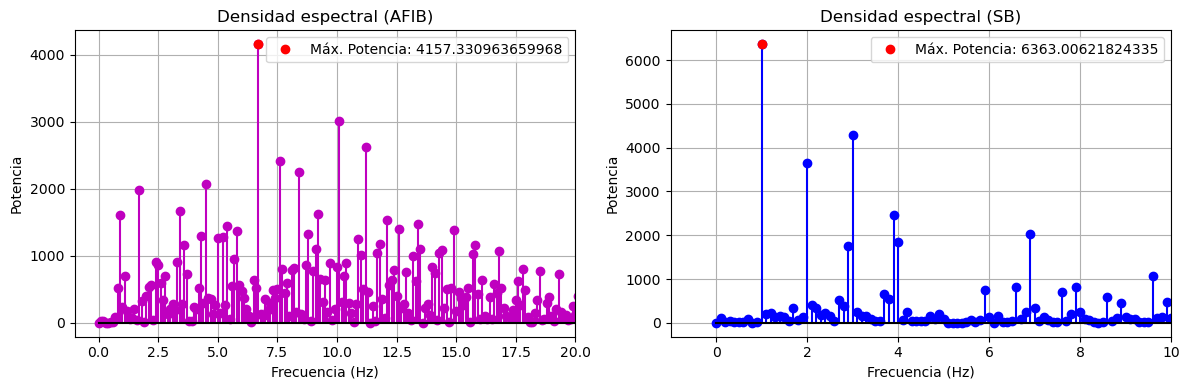

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4)) 
max_AFIB = max(power_spectru_AFIB) 
max_AFIB_freq = frequencies_AFIB[power_spectru_AFIB.argmax()]  

max_SB = max(power_spectru_SB) 
max_SB_freq = frequencies_SB[power_spectru_SB.argmax()]  
axs[0].stem(frequencies_AFIB, power_spectru_AFIB, linefmt='m-', markerfmt='mo', basefmt='k-')
axs[0].set_ylabel("Potencia")
axs[0].set_xlabel("Frecuencia (Hz)")
axs[0].set_title("Densidad espectral (AFIB)")
axs[0].set_xlim(-1,20)
axs[0].plot(max_AFIB_freq, max_AFIB, 'ro', label=f'Máx. Potencia: {max_AFIB}')  # Marcador rojo

axs[0].grid(True)


axs[1].stem(frequencies_SB, power_spectru_SB, linefmt='b-', markerfmt='bo', basefmt='k-')
axs[1].set_ylabel("Potencia")
axs[1].set_xlabel("Frecuencia (Hz)")
axs[1].set_title("Densidad espectral (SB)")
axs[1].set_xlim(-1,10)
axs[1].plot(max_SB_freq, max_SB, 'ro', label=f'Máx. Potencia: {max_SB}')  # Marcador rojo

axs[1].grid(True)

axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')

plt.tight_layout()

plt.show()

Nuevamente, para los sujetos seleccionados de manera aleatoria, podemos observar que para el sujeto con AFIB, la frecuencia de máxima potencia toma un valor mayor a 1.7 Hz (frecuencia de pulso de un ECG en condiciones normales), de 6.7 Hz. En cuanto al sujeto con SB, la frecuencia de máxima potencia toma un valor de 1 Hz, dando cuenta de las diferencias en frecuencia de ambas señales. No obstante, no es concluyente debido a que sólo se está realizando comparación entre 2 sujetos, por lo que no son muestras representativas, y se harán estimaciones con los promedios de la frecuencia máxima para ambas arritmias más adelante.

# 5. Suma de frecuencias significativas para bicoherencia

In [107]:
def frecuencias_significativas(signal_bicoherence, N):
    threshold = np.sqrt((9.2) / (2 * N))
    significativas = np.sum(signal_bicoherence > threshold)
    return significativas

In [109]:
suma_SB = frecuencias_significativas(sim_SB, 200)

In [111]:
suma_SB

94

In [113]:
suma_AFIB = frecuencias_significativas(sim_AFIB, 10)

In [115]:
suma_AFIB

73

# 6. Rutina

### *1) Aplicación de las funciones detrend, compress, de biespectro y bicoherencia a cada una de las señales.*
### *2) Cálculo de la fMP (frecuencia de máxima potencia) para cada señal ECG.*
### *3) Suma de las frecuencias significativas (sFSB)*
### *4) Almacenamiento en un DataFrame*

In [152]:
directorio = directorio_actual
fs = 500  
nsegmentos = 500 
N = 10  

In [154]:
def preprocess(señal):
    detrend1 = detrend(señal)
    compression = compress(detrend1)
    detrend2 = detrend(compression)
    return detrend2

In [156]:
ruta_carpeta = directorio_actual + '/AFIB'
archivo = 'MUSE_20180115_133556_54000.csv' 
ruta_archivo = ruta_carpeta + "/" + archivo
columnas=['II']
data = pd.read_csv(ruta1, delimiter=',', names=columnas)
signal_SB = data["II"].values
try:
    detrend2_SB = preprocess(signal_SB)
except FileNotFoundError:
    print(f'El archivo {archivo} no se encontró en {ruta_carpeta}.')

In [158]:
ruta_archivo

'C:\\Users\\USUARIO\\Documents\\Bioingeniería\\Bioseñales\\Proyectos\\Proyecto 2/AFIB/MUSE_20180115_133556_54000.csv'

In [160]:
signal_SB

array([-10.663 ,  -4.8841,  -1.6994, ..., -19.36  ,  -1.6816,  16.723 ])

In [162]:
detrend2_SB

array([-0.04084577, -0.03647689, -0.03406986, ..., -0.05443175,
       -0.04106389, -0.02714683])

In [164]:
biespectro, bicoherencia = bicoherencia_biespectro(detrend2_SB, fs, nsegmentos)
simetria_bicoherencia = simetria(bicoherencia)

In [165]:
frequencies, power_spectrum, max_freq = potenciaMax(detrend2_SB, fs)
nfrec_significativas = frecuencias_significativas(simetria_bicoherencia, N)
data = {'Registros': ruta_archivo, 'Estado': 'SB', 'fMP': max_freq, 'sFSB': nfrec_significativas}
print(data)

{'Registros': 'C:\\Users\\USUARIO\\Documents\\Bioingeniería\\Bioseñales\\Proyectos\\Proyecto 2/AFIB/MUSE_20180115_133556_54000.csv', 'Estado': 'SB', 'fMP': 5.9, 'sFSB': 60}


In [168]:
max_freq

5.9

In [170]:
nfrec_significativas

60

In [172]:
def procesar_señales(directorio_actual, fs, nsegmentos, N):
    resultados = []  
    bicoherencias_por_carpeta = {'SB': [], 'AFIB': []} 
    carpetas = ['SB', 'AFIB']

    for carpeta in carpetas:
        ruta_carpeta = os.path.join(directorio_actual, carpeta) 
        
        for archivo in os.listdir(ruta_carpeta):  
            if archivo.endswith('.csv'):  #
                ruta_archivo = os.path.join(ruta_carpeta, archivo)  # Ruta completa del archivo

                try:
                    data = pd.read_csv(ruta_archivo, delimiter=',', names=['II'])
                    signal = data["II"].values

                    detrend_signal = preprocess(signal)

                    biespectro, bicoherencia = bicoherencia_biespectro(detrend_signal, fs, nsegmentos)
                    simetria_bicoherencia = simetria(bicoherencia)

                    frequencies, power_spectrum, max_freq = potenciaMax(detrend_signal, fs)
                    nfrec_significativas = frecuencias_significativas(simetria_bicoherencia, N)

                    datos = {
                        'Registros': archivo,
                        'Estado': carpeta,
                        'fMP': max_freq,
                        'sFSB': nfrec_significativas
                    }
                    resultados.append(datos)
                    bicoherencias_por_carpeta[carpeta].append(bicoherencia)  # Almacenar la bicoherencia en la carpeta correspondiente

                except FileNotFoundError:
                    print(f'El archivo {archivo} no se encontró en {ruta_carpeta}.')
                except Exception as e:
                    print(f'Ocurrió un error al procesar el archivo {archivo}: {e}')

    df_resultados = pd.DataFrame(resultados)

    promedios_bicoherencia = {}
    for carpeta in carpetas:
        if bicoherencias_por_carpeta[carpeta]: 
            promedio = np.mean(bicoherencias_por_carpeta[carpeta], axis=0)
            promedios_bicoherencia[carpeta] = promedio

    return df_resultados, promedios_bicoherencia

In [177]:
directorio = directorio_actual
fs = 500  
nsegmentos = 500 
N = 10  

df_Data, promedios_bicoherencia = procesar_señales(directorio, fs, nsegmentos, N)

#### DataFrame resultante

In [179]:
df_Data

,Registros,Estado,fMP,sFSB
0,MUSE_20180111_155758_17000.csv,SB,3.7,91
1,MUSE_20180111_155839_67000.csv,SB,2.9,88
2,MUSE_20180111_155859_36000.csv,SB,2.8,86
3,MUSE_20180111_155907_78000.csv,SB,2.8,88
4,MUSE_20180111_160033_11000.csv,SB,0.8,106
...,...,...,...,...
5664,MUSE_20180712_161449_58000.csv,AFIB,12.4,75
5665,MUSE_20180712_161451_72000.csv,AFIB,3.9,78
5666,MUSE_20180712_161452_78000.csv,AFIB,3.2,61
5667,MUSE_20180712_161503_00000.csv,AFIB,4.1,66


# Análisis 

# 7. Bicoherencias promediadas para cada arritmia 

In [183]:
bicoherencia_promedio_SB = simetria(promedios_bicoherencia['SB'])
bicoherencia_promedio_AFIB =  simetria(promedios_bicoherencia['AFIB'])

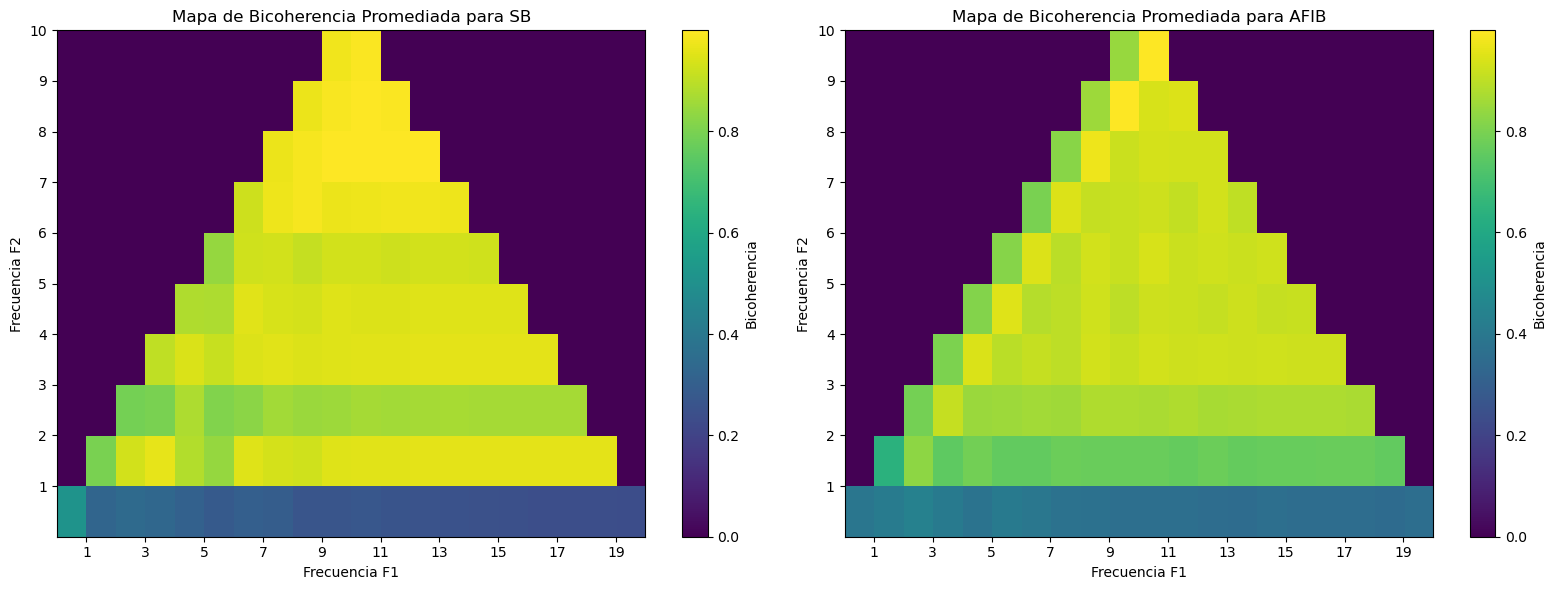

In [185]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # 1 fila, 2 columnas

bi1 = axs[0].imshow(bicoherencia_promedio_SB, extent=(0, 20, 0, 10), origin='lower', cmap='viridis', aspect='auto')
axs[0].set_title('Mapa de Bicoherencia Promediada para SB')
axs[0].set_xlabel('Frecuencia F1')
axs[0].set_ylabel('Frecuencia F2')
axs[0].set_xticks(np.arange(1, 21, 2))  # Ajuste de ticks en el eje x
axs[0].set_yticks(np.arange(1, 11, 1))  # Ajuste de ticks en el eje y
axs[0].grid(False)


cbar1 = fig.colorbar(im1, ax=axs[0], label='Bicoherencia')

bi2 = axs[1].imshow(bicoherencia_promedio_AFIB, extent=(0, 20, 0, 10), origin='lower', cmap='viridis', aspect='auto')
axs[1].set_title('Mapa de Bicoherencia Promediada para AFIB')
axs[1].set_xlabel('Frecuencia F1')
axs[1].set_ylabel('Frecuencia F2')
axs[1].set_xticks(np.arange(1, 21, 2))
axs[1].set_yticks(np.arange(1, 11, 1))
axs[1].grid(False)

cbar2 = fig.colorbar(im2, ax=axs[1], label='Bicoherencia')
plt.tight_layout()

plt.show()

Los mapas de bicoherencia promediada para cada estado (SB y AFIB) entregan información sobre la coherencia de fase cuadrática entre pares de frecuencias. Un valor alto de bicoherencia indica una fuerte interacción entre esas dos frecuencias. Para el caso del grupo con diagnóstico de AFIB hay una menor bicoherencia entre frecuencias en comparación con SB, lo que podría interpretarse como débiles interacciones no lineales. Las señales de sujetos con SB muestran un patrón de coherencia con mayor regularidad, siendo lo anterior a su vez indicador de una mayor sincronización en la señal, mientras que se podría decir que las señales con fibrilación auricular tienen un patrón con mayor dispersión, junto con una menor intensidad, y una menor cantidad de frecuencias en coherencia de fase cuadrática, reflejando el comportamiento irregular de estas señales debido a la contracción descoordinada de las aurículas. 

# 7. Análisis estadístico descriptivo

Inicialmente, se hace un resumen estadístico para ambos grupos (SB y AFIB)

### Resumen estadístico grupo SB

In [191]:
SB_data= df_Data[df_Data["Estado"] == "SB"][["Estado", "fMP","sFSB"]]
SB_data.describe()

,fMP,sFSB
count,3889.000000,3889.000000
mean,2.692079,85.083569
std,2.380113,9.789212
min,0.200000,28.000000
25%,1.000000,78.000000
50%,2.700000,88.000000
75%,3.700000,90.000000
max,50.000000,110.000000


### Resumen estadístico grupo AFIB

In [194]:
AFIB_data= df_Data[df_Data["Estado"] == "AFIB"][["Estado", "fMP","sFSB"]]
AFIB_data.describe()

,fMP,sFSB
count,1780.000000,1780.000000
mean,4.289663,69.392697
std,3.283687,17.274794
min,0.100000,3.000000
25%,2.400000,58.000000
50%,3.400000,72.000000
75%,4.900000,82.000000
max,50.000000,110.000000


En el resumen estadístico podemos observar que las señales ECG para el grupo con un estado de Bradicardia Sinusal alcanzan su mayor potencia espectral en una frecuencia de 2.6 Hz en promedio, siendo menor en comparación a la frecuencia donde las señales ECG con presencia de fibrilación auricular alcanzan su máxima potencia, para la cual se obtuvo una estimación promediada de 4.2 Hz, siendo este resultado acorde con una de las principales diferencias estructurales entre las señales de ambas arritmias, la cual radica en las frecuencias de pulso, teniendo las señales ECG con AFIB frecuencias de pulso incrementadas en comparación a las señales de ECG con SB. Así mismo, para las señales ECG con AFIB se obtuvo un menor número de frecuencias significativas para bicoherencia (sFSB) en promedio en comparación con las señales ECG con SB, dando cuenta de los patrones espectrales dispersos presentes en las señales ECG durante episodios de fibrilación auricular, donde la frecuencia tiene una mayor irregularidad, concluyendo así que se obtuvo el resultado esperado. 

Con el objetivo de visualizar la distribución de los datos, se hará un histograma 

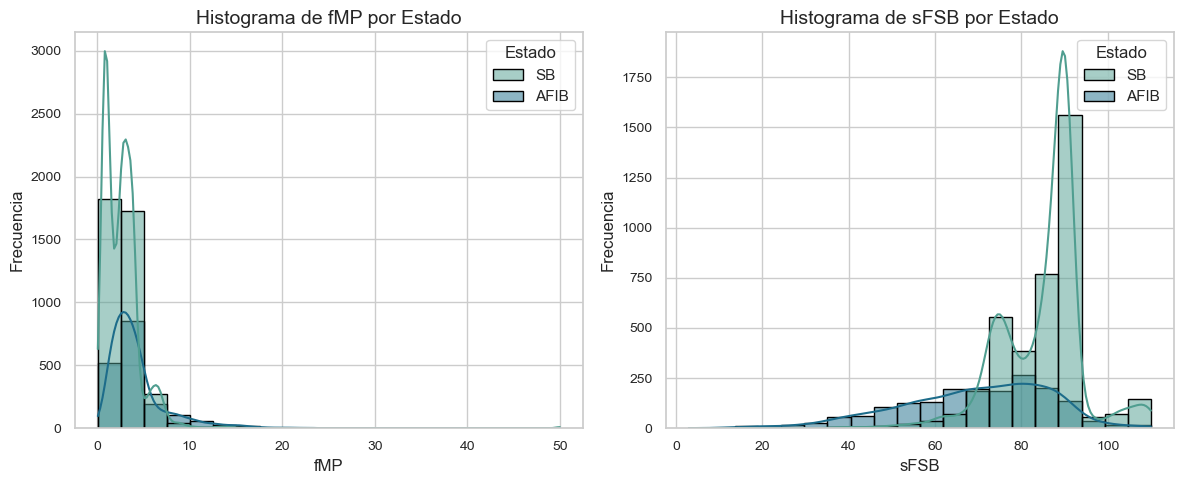

In [198]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=df_Data, x='fMP', hue='Estado', bins=20, kde=True, ax=axs[0], palette='crest', edgecolor='black')
axs[0].set_title('Histograma de fMP por Estado', fontsize=14)
axs[0].set_xlabel('fMP', fontsize=12)
axs[0].set_ylabel('Frecuencia', fontsize=12)
axs[0].tick_params(axis='both', labelsize=10)
axs[0].grid(True)

sns.histplot(data=df_Data, x='sFSB', hue='Estado', bins=20, kde=True, ax=axs[1], palette='crest', edgecolor='black')
axs[1].set_title('Histograma de sFSB por Estado', fontsize=14)
axs[1].set_xlabel('sFSB', fontsize=12)
axs[1].set_ylabel('Frecuencia', fontsize=12)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].grid(True)

plt.tight_layout()
plt.show()

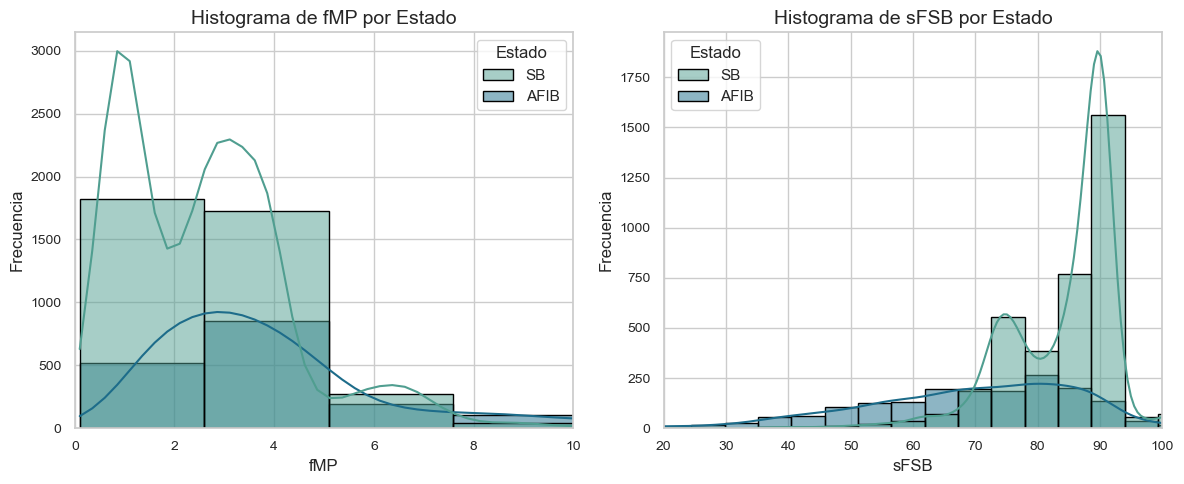

In [199]:
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=df_Data, x='fMP', hue='Estado', bins=20, kde=True, ax=axs[0], palette='crest', edgecolor='black')
axs[0].set_title('Histograma de fMP por Estado', fontsize=14)
axs[0].set_xlabel('fMP', fontsize=12)
axs[0].set_ylabel('Frecuencia', fontsize=12)
axs[0].set_xlim(0, 10)
axs[0].tick_params(axis='both', labelsize=10)
axs[0].grid(True)

sns.histplot(data=df_Data, x='sFSB', hue='Estado', bins=20, kde=True, ax=axs[1], palette='crest', edgecolor='black')
axs[1].set_title('Histograma de sFSB por Estado', fontsize=14)
axs[1].set_xlabel('sFSB', fontsize=12)
axs[1].set_xlim(20,100)
axs[1].set_ylabel('Frecuencia', fontsize=12)
axs[1].tick_params(axis='both', labelsize=10)
axs[1].grid(True)

plt.tight_layout()
plt.show()

Al visualizar el histograma, se podría asumir que las métricas (tanto fMP como sFSB) no siguen una distribución normal para ninguno de los dos grupos (no obstante, es importante corroborarlo mediante una prueba de normalidad). En la condición de arritmia AFIB, en la métrica sFSB se observa una asimetría hacia la derecha, y para fMP una simetría hacia la izquierda. Para el caso del estado SB, en la fMP se observa que la concentración de la potencia máxima se encuentra en frecuencias menores a 2 Hz, seguida de frecuencias menores a 4 Hz. Para el estado AFIB, la potencia máxima se encuentra más distribuida entre diferentes frecuencias, sin embargo, la mayor concentración se da en frecuencias entre 2-4 Hz.

Al analizar la distribución de la variable sFSB para los datos, se puede observar nuevamente que el número máximo de frecuencias significativas se distribuye en distintos valores, pero para el caso de la condición SB, esta distribución está muy marcada para un sFSB de 90 aproximadamente, obteniéndose la segunda mayor concentración entre una suma resultante entre 70-80. 

## Diagramas de violín

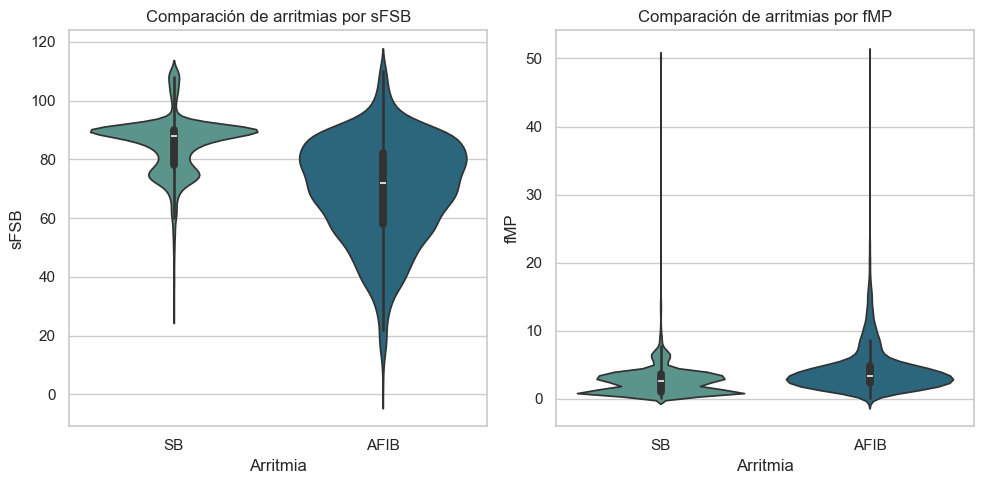

In [204]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.violinplot(data=df_Data, x='Estado', y='sFSB', hue='Estado', palette="crest", legend=False, ax=axs[0])
axs[0].set_title('Comparación de arritmias por sFSB')
axs[0].set_xlabel('Arritmia')
axs[0].set_ylabel('sFSB')

sns.violinplot(data=df_Data, x='Estado', y='fMP', hue='Estado', palette="crest", legend=False, ax=axs[1])
axs[1].set_title('Comparación de arritmias por fMP')
axs[1].set_xlabel('Arritmia')
axs[1].set_ylabel('fMP')

plt.tight_layout()
plt.show()


Para el gráfico de comparación de arritmias por sFSB, se puede observar que la distribución de los datos para las señales AFIB es más ancha, lo que indica una mayor variabilidad en los valores sFSB para dicha arritmia, adicionalmente, se observa una concentración central, pero también se tienen valores extremos situados en los rangos más bajos. Por su parte, en el estado SB se tiene una distribución menos variable, con una menor dispersión hacia valores más bajos y unos valores extremos menos alejados del rango intercuartílico, en comparación con el estado AFIB. Los datos para este estado tienen una tendencia a estar más concentrados alrededor de un valor específico.

En el gráfico fMP para ambas arritmias, SB tiene valores de fMP agrupados los rangos inferiores, y una variabilidad menor en comparación con los valores de fMP para el estado AFIB, donde se evidencia una distribución visiblemente más amplia, y una media más elevada que en SB. 

# 7.1 Análisis descriptivo: conclusiones 

Con los gráficos elaborados para bicoherencia promedio, junto con los histogramas y los diagramas de violín, tanto para las métricas fMP como sFSB extraídas para las señales ECG de ambas arritmias, se evidenció que los datos de las señales ECG para sujetos con la arritmia AFIB presentan una mayor irregularidad, lo que era esperado debido a la naturaleza desorganizada de la fibrilación auricular, teniendo un menor número de frecuencias significativas en bicoherencia, lo que se puede interpretar como un menor acople entre las frecuencias, y una mayor dispersión en la distribución de los datos. En contraste, las señales ECG para el grupo etiquetado como SB, se visualizó una varianza menor en comparación con AFIB, con una distribución relativamente compacta, teniendo valores más consistentes para sFSB como para fMP, y estos últimos agrupándose en rangos más bajos en comparación con AFIB. Adicionalmente, en el gráfico de bicoherencia se pudieron observar patrones más estructurados, característico en condiciones de un ritmo cardíaco estable como el que se presenta en la bradicardia sinusal, donde los intervalos R-R son regulares y se guarda similitud con un ECG en condiciones normales. 

Con el análisis descriptivo, se concluye que las métricas presentan diferentes comportamientos para ambos estados debido a las diferencias estructurales de las señales ECG distinguidas en distinta variabilidad, intensidad de bicoherencia, número de frecuencias acopladas, siendo posible que al realizar la comparación entre ambas métricas y evaluarlas mediante pruebas estadísticas, estas entreguen información diferencial para distinguir entre diagnósticos de SB y AFIB. 

# 8. Análisis estadístico inferencial

Para determinar qué prueba deberíamos utilizar para hacer la comparación entre ambos grupos para cada métrica, inicialmente se verifica si se cumple con los supuestos para utilizar muestras paramétricas. 

In [211]:
SB_sFSB = df_Data[df_Data["Estado"] == "SB"][["Estado", "sFSB"]]
SB_sFSB= SB_sFSB['sFSB'].values

AFIB_sFSB = df_Data[df_Data["Estado"] == "AFIB"][["Estado", "sFSB"]]
AFIB_sFSB= AFIB_sFSB['sFSB'].values

SB_fMP = df_Data[df_Data["Estado"] == "SB"][["Estado", "fMP"]]
SB_fMP = SB_fMP['fMP'].values

AFIB_fMP = df_Data[df_Data["Estado"] == "AFIB"][["Estado", "fMP"]]
AFIB_fMP = AFIB_fMP['fMP'].values

## *Prueba de normalidad: Kolmogorov-Smirnov para cada estado*

Dado que el tamaño de muestra es robusto (n > 5000 datos), se hará una prueba de Kolmogorov Smirnov, que es ideal para una gran cantidad de datos

**Hipótesis prueba de normalidad**

**Ho:** Los datos siguen una distribución normal.

**Ha:** Los datos no siguen una distribución normal

### *Pruebas de normalidad para SB*

In [215]:
alfa = 0.05  

stat_fMP_SB, p_fMP_SB = stats.kstest(SB_fMP, 'norm')
print(f'P-valor para fMP para el grupo con SB es: {p_fMP_SB:.4f}')
if p_fMP_SB > alfa:
    print('No se rechaza la hipótesis nula. Los datos de fMP del grupo con SB siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos de fMP del grupo con SB no siguen una distribución normal.')

# Test de normalidad para sFSB
stat_normalidad_sFSB_SB, p_sFSB_SB = stats.kstest(SB_sFSB, 'norm')
print(f'P-valor para sFSB para el grupo con SB es: {p_sFSB_SB:.4f}')
if p_sFSB_SB > alfa:
    print('No se rechaza la hipótesis nula. Los datos de sFSB del grupo con SB siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos de sFSB del grupo con SB no siguen una distribución normal.')


P-valor para fMP para el grupo con SB es: 0.0000
Se rechaza la hipótesis nula. Los datos de fMP del grupo con SB no siguen una distribución normal.
P-valor para sFSB para el grupo con SB es: 0.0000
Se rechaza la hipótesis nula. Los datos de sFSB del grupo con SB no siguen una distribución normal.


### *Pruebas de normalidad para AFIB*

In [218]:
alfa = 0.05  

stat_fMP_AFIB, p_fMP_AFIB = stats.kstest(AFIB_fMP, 'norm')
print(f'P-valor para fMP para el grupo con AFIB es: {p_fMP_AFIB:.4f}')
if p_fMP_AFIB > alfa:
    print('No se rechaza la hipótesis nula. Los datos de fMP del grupo con AFIB siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos de fMP del grupo con AFIB no siguen una distribución normal.')

stat_normalidad_sFSB_AFIB, p_sFSB_AFIB = stats.kstest(AFIB_sFSB, 'norm')
print(f'P-valor para sFSB para el grupo con AFIB es: {p_sFSB_AFIB:.4f}')
if p_sFSB_AFIB > alfa:
    print('No se rechaza la hipótesis nula. Los datos de sFSB del grupo con AFIB siguen una distribución normal.')
else:
    print('Se rechaza la hipótesis nula. Los datos de sFSB del grupo con AFIB no siguen una distribución normal.')


P-valor para fMP para el grupo con AFIB es: 0.0000
Se rechaza la hipótesis nula. Los datos de fMP del grupo con AFIB no siguen una distribución normal.
P-valor para sFSB para el grupo con AFIB es: 0.0000
Se rechaza la hipótesis nula. Los datos de sFSB del grupo con AFIB no siguen una distribución normal.


Dado que los canales no siguen una distribución normal, una de las pruebas recomendadas para evaluar la homocedasticidad es la Prueba de Levene.
Si el valor p de la prueba de Levene es superior a 0.05, las varianzas no son significativamente diferentes entre sí (es decir, se cumple el supuesto de homogeneidad de la varianza). Si el valor p de la prueba de Levene es inferior a 0.05, entonces existe una diferencia significativa entre las varianzas.


## *Prueba de homocedasticidad: Levene*

**Hipótesis prueba de homocedasticidad**

**Ho:** Los datos tienen varianzas iguales.

**Ha:** Los datos no tienen varianzas iguales.

In [222]:
fMP = df_Data["fMP"]
sFSB = df_Data["sFSB"]
stat_homogeneidad_sFSB_fMP, p_valor_homogeniedad_sFSB_fMP = stats.levene(fMP, sFSB, center='median')
print(f'P-valor: {p_valor_homogeniedad_sFSB_fMP:.4f}')
alfa = 0.05  # Nivel de significancia
if p_valor_homogeniedad_sFSB_fMP > alfa:
  print('No se rechaza la hipótesis nula. Los datos proceden de distribuciones con la misma varianza.')
else:
  print('Se rechaza la hipótesis nula. Los datos no proceden de distribuciones con la misma varianza.')

P-valor: 0.0000
Se rechaza la hipótesis nula. Los datos no proceden de distribuciones con la misma varianza.


## *Supuesto de independencia*
Ya que los grupos representan poblaciones distintas, con diferentes condiciones clínicas, en este caso de arritmia, se asume que cumplen con el supuesto de independencia.

Dado que no se cumplen con los supuestos requeridos para realizar una prueba paramétrica que permita realizar una comparación de los datos, se empleará la prueba no paramétrica U de Mann-Whitney para identificar si las métricas evaluadas entregan información diferencial entre los dos estados (SB y AFIB). Se considera que es adecuada ya que el objetivo es hacer la comparación entre dos grupos que no siguen una distribución normal.

## *Prueba no paramétrica: U de Mann-Whitney*

Las características que los datos deben tener para poder ser analizados por la prueba U de Mann Whitney son: 

**1.** La variable dependiente debe medirse a nivel ordinal o continuo.

**2.** La variable independiente debe consistir en dos grupos.

**3.** Debe haber independencia de las observaciones de cada grupo.

**4.** Las dos variables se distribuyen de forma anormal.

### Para identificar si la métrica fMP es discriminatoria entre estados

**Hipótesis Prueba U de Mann Whitney**

**Ho:** La fMP no entrega información diferencial entre los sujetos con SB y AFIB

**Ha:**  La fMP entrega información diferencial entre los sujetos con SB y AFIB

In [229]:
alfa = 0.05 
stat_np_fMP, p_np_fMP = stats.mannwhitneyu(SB_fMP, AFIB_fMP, alternative='two-sided')
if p_np_fMP < alfa:
    print(f'''p value = {p_np_fMP} 
    
Se rechaza la hipótesis nula. La fMP difiere significativamente entre estados (SB y AFIB)''')
    
else:
    print(f'''
    p value = {p_np_fMP} No hay suficiente evidencia para rechazar la hipótesis nula. 

La fMP no difiere entre estados (SB y AFIB)''')

p value = 2.8670168849961355e-118 
    
Se rechaza la hipótesis nula. La fMP difiere significativamente entre estados (SB y AFIB)


### Para identificar si la métrica sFSB es discriminatoria entre estados

**Hipótesis Prueba U de Mann Whitney**

**Ho:** La sFSB no entrega información diferencial entre los sujetos con SB y AFIB

**Ha:**  La sFSB entrega información diferencial entre los sujetos con SB y AFIB

In [236]:
stat_np_sFSB, p_np_sFSB = stats.mannwhitneyu(SB_sFSB, AFIB_sFSB, alternative='two-sided')
alfa = 0.05  # Nivel de significancia
if p_np_sFSB < alfa:
    print(f'''p value = {p_np_sFSB} Se rechaza la hipótesis nula.

La sFSB difiere significativamente entre estados (SB y AFIB)''')
    
else:
    print(f'''p value = {p_np_sFSB} No hay suficiente evidencia para rechazar la hipótesis nula. 
    
La sFSB no difiere significativamente entre estados (SB y AFIB)''')

p value = 5.260744775070678e-275 Se rechaza la hipótesis nula.

La sFSB difiere significativamente entre estados (SB y AFIB)


Las enfermedades cardiovasculares son una de las principales causas de muerte en todo el mundo. Patologías como la arritmia, que se refiere a un ritmo cardíaco anormal, son de las afecciones más comunes. Entre los tipos de arritmias, destaca la fibrilación auricular (AFIB), donde  las aurículas laten de forma caótica e irregular, sin sincronización con los ventrículos. Esta condición es una de las más frecuentes y, al mismo tiempo, de las menos detectables, ya que puede ser asintomática. Para la detección temprana de la fibrilación auricular es necesario realizar un monitoreo continuo, esto puede reducir significativamente el riesgo de sufrir accidentes cerebrovasculares [9]. Por otro lado, la bradicardia sinusal (SB) es otra afección común, pero a diferencia de la AFIB, en la SB el corazón late a una frecuencia más baja de lo normal, lo que dificulta el suministro adecuado de sangre al cuerpo [10].

Este comportamiento en frecuencia se observa en los resultados del gráfico de densidad espectral, donde el rango de frecuencias es más reducido en los sujetos con bradicardia sinusal, quienes presentan una frecuencia cardíaca más baja, en comparación con los sujetos con fibrilación auricular, que muestran una frecuencia cardíaca rápida y desorganizada. En cuanto a la magnitud de la potencia, la bradicardia sinusal (SB) tiende a mostrar una mayor magnitud. Esto se debe a que, aunque la frecuencia cardíaca es más baja en comparación con la fibrilación auricular (AFIB), la potencia máxima se concentra en esas frecuencias más bajas. En contraste, en pacientes con AFIB, la frecuencia cardíaca es rápida y desorganizada, lo que provoca que la potencia se disperse en un rango más amplio de frecuencias, reduciendo su magnitud en una frecuencia específica. 

Para el análisis inferencial, se inició con la prueba de normalidad de Kolmogorov-Smirnov, que reveló que los datos no cumplían con los supuestos de una distribución normal y una prueba de homocedasticidad que nos indicó que los datos no proceden de distribuciones con la misma varianza. En consecuencia, se aplicó la prueba U de Mann para comparar las distribuciones y determinar si provenían del mismo origen, lo que resultó en diferencias significativas. Esto evidencia la capacidad del sistema para diferenciar entre la arritmia tipo fibrilación auricular (AFIB) y la bradicardia sinusal (SB). Por lo tanto, se concluye que el análisis espectral de orden superior, como la bicoherencia, es un método efectivo para clasificar anomalías cardíacas.

Los resultados para p-value  obtenidos de la prueba U Mann Whitney son muy bajos, esto  indica que la diferencia entre los ECG de fibrilación auricular y bradicardia sinusal evaluados en la frecuencia de máxima potencia es extremadamente significativa. Un p-valor tan bajo sugiere que la probabilidad de que la diferencia observada ocurra por azar es prácticamente nula, y por lo tanto, se puede concluir que existe una diferencia muy significativa entre las dos condiciones.Posteriormente se realizó de nuevo la prueba de U Mann Whitney  de al comparar las frecuencias significativas en bicoherencia entre fibrilación auricular y bradicardia sinusal,  en donde se evidencia igual que en el caso anterior valores muy bajos para el p-value,  esto indica que hay una diferencia extremadamente significativa  entre los dos grupos. Un p-valor tan pequeño sugiere que la diferencia observada no es debida al azar y que las distribuciones de las frecuencias significativas en bicoherencia son notablemente distintas entre ambas patologías.

## Conclusiones 

* Los mapas de bicoherencia son herramientas efectivas para la identificación de arritmias como la fibrilación auricular (AFIB) y la bradicardia sinusal (SB), ya que permiten visualizar la sincronización de las frecuencias cardíacas y sus interacciones.

* La magnitud de la potencia en el análisis de densidad espectral  proporciona información valiosa sobre el estado del ritmo cardíaco. En SB, la mayor magnitud de potencia en frecuencias bajas indica un ritmo más regular, a diferencia de la AFIB, donde la potencia se distribuye de manera más difusa.

* El comportamiento de patologías como la fibrilación auricular (AFIB) y la bradicardia sinusal (SB) puede diferenciarse por factores como la edad. En este estudio, los sujetos presentaban un rango de edades diversas, lo que sugiere que la manifestación de estas arritmias pueden variar significativamente. Esta variabilidad impacta en los valores de frecuencia de máxima potencia (fMP) y suma de frecuencias significativas en bicoherencia (sFSB).

* La diferenciación de las arritmias (SB y AFIB) mediante el análisis de la potencia espectral y bicoherencia podría permitir a su vez la realización de un diagnóstico diferencial. Las conclusiones del proyecto realizado podrían ampliarse más adelante estudiando el tamaño del efecto de los hallazgos obtenidos, junto con la correlación con variables demográficas como la edad de los sujetos. 

## Referencias 

[1] Hafeez Y, Grossman SA. Sinus Bradycardia. 2023 Aug 7. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2024 Jan–. PMID: 29630253.

[2] Nesheiwat Z, Goyal A, Jagtap M. Atrial Fibrillation. 2023 Apr 26. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2024 Jan–. PMID: 30252328.

[3] M. Gadaleta et al., “Prediction of atrial fibrillation from at-home single-lead ECG signals without arrhythmias”, npj Digit. Medicine, vol. 6, n.º 1, diciembre de 2023. Accedido el 21 de octubre de 2024. [En línea]. Disponible: https://doi.org/10.1038/s41746-023-00966-w

[4] J. Zheng et al., “Optimal Multi-Stage Arrhythmia Classification Approach”, Scientific Rep., vol. 10, n.º 1, febrero de 2020. Accedido el 21 de octubre de 2024. [En línea]. Disponible: https://doi.org/10.1038/s41598-020-59821-7

[5] L. Rung Liu, “An Arrhythmia classification approach via deep learning using single-lead ECG without QRS wave detection”, Heliyon, vol. 10, n.º 5, 2024. [En línea]. Disponible: https://www.sciencedirect.com/science/article/pii/S2405844024032316

[6] A. M. Richardson and W. S. Hodgkiss, “APPLICATIONS OF BISPECTRAL ANALYSIS”, Univ. California, San Diego, 1993. [En línea]. Disponible: https://apps.dtic.mil/sti/tr/pdf/ADA291989.pdf

[7] Y. Kotriwar, S. Kachhara, K. P. Harikrishnan y G. Ambika, “Higher order spectral analysis of ECG signals”, Indian Inst. Sci. Educ. Res. (IISER) Pune, 2018. [En línea]. Disponible: https://arxiv.org/pdf/1809.08451

[8] A. V. Totsky y A. A. Zelensky, Bispectral Methods of Signal Processing. 2015. [En línea]. Disponible: https://www.degruyter.com/document/doi/10.1515/9783110368888/html

[9] M. Cárdenas, “Atrial fibrillation”, Arch. Cardiol., vol. 77, supl.2, 2007. [En línea]. Disponible: https://www.scielo.org.mx/scielo.php?script=sci_arttext&amp;pid=S1405-99402007000600003

[10] “BRADICARDIA SINTOMÁTICA Y USO DE MARCAPASOS EN EL SERVICIO DE URGENCIAS”, rev.fac.med., vol. 55, n.º 3, 2007. [En línea]. Disponible: http://www.scielo.org.co/scielo.php?script=sci_arttext&amp;pid=S0120-00112007000300007